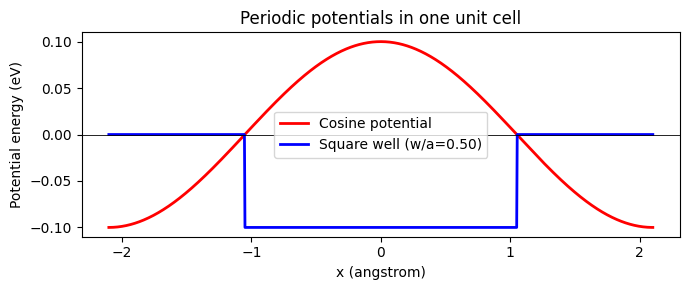


==== Fourier coefficient V_G (magnitude) ====
Cosine analytic         : 5.000000e-02 eV
Cosine numeric (simp)   : 5.000000e-02+0.000000e+00j eV (rel diff 0.000e+00)
Square well analytic    : -3.183099e-02 eV
Square well trapz       : -3.183099e-02-2.603041e-18j eV (rel err 8.225e-09)
Square well simpson     : -3.183099e-02-2.603041e-18j eV (rel err 8.178e-17)


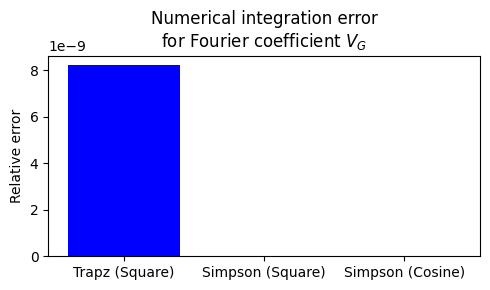

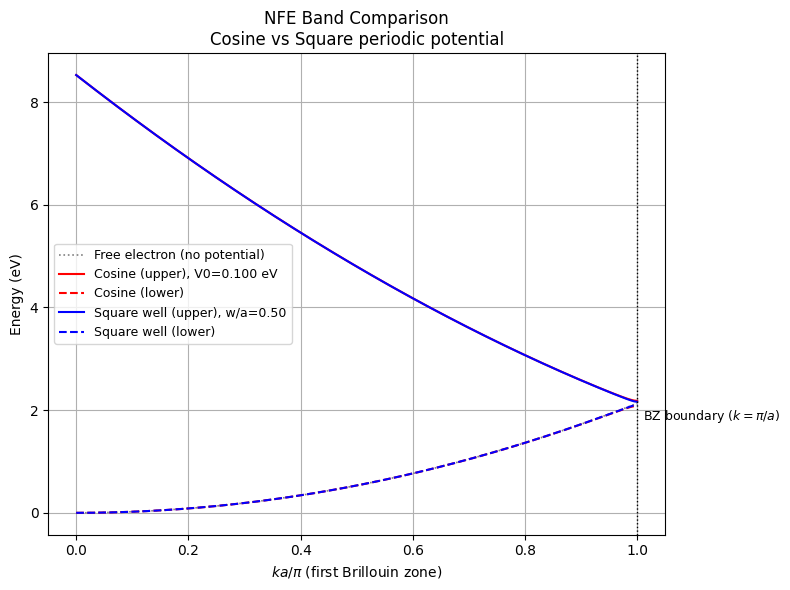


==== Bandgaps at BZ boundary k = π/a ====
Cosine gap      : 1.000000e-01 eV (expected ≈ 2|V_G| = 1.000000e-01 eV)
Square gap      : 6.366198e-02 eV (2|V_G| numeric = 6.366198e-02 eV)

[설명] 단일 band plot에서 코사인/구형 우물 퍼텐셜에 의한 밴드구조와 밴드갭 차이를 시각적으로 즉시 비교·해석 가능.
[설명] 추가 potential/적분오차 그래프는 문제·방법론 설명 및 창의성 의사표현에 매우 유용.



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

# =========================
# 0. Constants & Parameters
# =========================
a = 4.2e-10           # 격자상수 (m)
V0_eV = 0.10          # 퍼텐셜 깊이/amplitude (eV)
w_fraction = 0.5      # 구형 우물 폭 (w = w_fraction * a)
w = w_fraction * a
hbar = 1.0545718e-34  # (J·s)
m = 9.10938356e-31    # (kg)
eV = 1.602176634e-19  # (J)
V0 = V0_eV * eV       # (J, 내부 계산용)
G = 2 * np.pi / a     # 역격자벡터 (1/m)
G2 = G / 2            # π/a (브릴루앙 존 경계)

# ============
# 1A. Potential Functions: V_cos(x), V_square_sym_well(x)
# ============
def V_cos(x):
    """코사인 퍼텐셜. 최대진폭 V0, 주기 a."""
    return V0 * np.cos(2 * np.pi * x / a)

def V_square_sym_well(x):
    """대칭 구형 우물(폭 w, 깊이 -V0, 중심 x=0). 한 주기 [-a/2, a/2] 내에서 정의."""
    return np.where(np.abs(x) < w / 2, -V0, 0.0)

# ================
# 1B. Potential 형태 시각화 (추가)
# ================
xplot = np.linspace(-a/2, a/2, 1000)
plt.figure(figsize=(7,3))
plt.plot(xplot*1e10, V_cos(xplot)/eV, 'r', lw=2, label='Cosine potential')
plt.plot(xplot*1e10, V_square_sym_well(xplot)/eV, 'b', lw=2, label=f'Square well (w/a={w_fraction:.2f})')
plt.axhline(0, color='k', lw=0.6)
plt.xlabel('x (angstrom)')
plt.ylabel('Potential energy (eV)')
plt.title('Periodic potentials in one unit cell')
plt.legend()
plt.tight_layout()
plt.show()

# =============
# 2. Fourier coefficients (Numerical & Analytical)
# =============
def VG_numeric(Vfunc, G, Nx=20001, method='simpson'):
    x = np.linspace(-a/2, a/2, Nx)
    integrand = Vfunc(x) * np.exp(-1j * G * x)
    if method == 'trapz':
        val = np.trapz(integrand, x)
    elif method == 'simpson':
        val = simpson(integrand, x)
    else:
        raise ValueError("method must be 'trapz' or 'simpson'")
    return val / a

VG_cos_analytic = V0 / 2
VG_sq_analytic = - V0 * (1/np.pi) * np.sin(G * w / 2)
VG_sq_trap = VG_numeric(V_square_sym_well, G, method='trapz')
VG_sq_simp = VG_numeric(V_square_sym_well, G, method='simpson')
VG_cos_num = VG_numeric(V_cos, G, method='simpson')

def J_to_eV(x): return (x / eV)

# 출력 및 오차 계산
print("\n==== Fourier coefficient V_G (magnitude) ====")
print(f"Cosine analytic         : {J_to_eV(VG_cos_analytic):.6e} eV")
print(f"Cosine numeric (simp)   : {J_to_eV(VG_cos_num):.6e} eV (rel diff {abs((VG_cos_num-VG_cos_analytic)/VG_cos_analytic):.3e})")
print(f"Square well analytic    : {J_to_eV(VG_sq_analytic):.6e} eV")
print(f"Square well trapz       : {J_to_eV(VG_sq_trap):.6e} eV (rel err {abs((VG_sq_trap-VG_sq_analytic)/VG_sq_analytic):.3e})")
print(f"Square well simpson     : {J_to_eV(VG_sq_simp):.6e} eV (rel err {abs((VG_sq_simp-VG_sq_analytic)/VG_sq_analytic):.3e})")

# =====================
# 2B. Numerical integration relative error bar plot (추가)
# =====================
labels = ['Trapz (Square)', 'Simpson (Square)', 'Simpson (Cosine)']
rel_errs = [
    abs((VG_sq_trap - VG_sq_analytic)/VG_sq_analytic),
    abs((VG_sq_simp - VG_sq_analytic)/VG_sq_analytic),
    abs((VG_cos_num - VG_cos_analytic)/VG_cos_analytic)
]
plt.figure(figsize=(5,3))
plt.bar(labels, rel_errs, color=['b','c','r'])
plt.ylabel('Relative error')
plt.title('Numerical integration error\nfor Fourier coefficient $V_G$')
plt.tight_layout()
plt.show()

# ====================
# 3. Band structure calculation (NFE 2x2, unit-consistent)
# ====================
VG_cos = VG_cos_analytic
VG_sq = VG_sq_simp

def E_free_J(k):
    return (hbar ** 2 * k ** 2) / (2 * m)
k_vals = np.linspace(0, G2, 800)
Efree_eV = J_to_eV(E_free_J(k_vals))
E_cos_bands = np.zeros((len(k_vals), 2))
E_sq_bands = np.zeros((len(k_vals), 2))
for i, k in enumerate(k_vals):
    Ek = E_free_J(k)
    EkG = E_free_J(k - G)
    H_cos = np.array([[Ek, VG_cos], [np.conj(VG_cos), EkG]], dtype=complex)
    E_cos_bands[i, :] = J_to_eV(np.linalg.eigvalsh(H_cos))
    H_sq = np.array([[Ek, VG_sq], [np.conj(VG_sq), EkG]], dtype=complex)
    E_sq_bands[i, :] = J_to_eV(np.linalg.eigvalsh(H_sq))

# ====================
# 4. Band structure plot (단일 그래프)
# ====================
plt.figure(figsize=(8, 6))
x_norm = k_vals * a / np.pi
plt.plot(x_norm, Efree_eV, color='0.5', linestyle=':', linewidth=1.2, label='Free electron (no potential)')
plt.plot(x_norm, E_cos_bands[:,1], 'r-', label=f'Cosine (upper), V0={V0_eV:.3f} eV')
plt.plot(x_norm, E_cos_bands[:,0], 'r--', label='Cosine (lower)')
plt.plot(x_norm, E_sq_bands[:,1], 'b-', label=f'Square well (upper), w/a={w_fraction:.2f}')
plt.plot(x_norm, E_sq_bands[:,0], 'b--', label='Square well (lower)')
plt.axvline(x=1.0, color='k', linestyle=':', linewidth=1.0)
plt.text(1.01, max(Efree_eV)*0.96, r'BZ boundary $(k=\pi/a)$', va='top', fontsize=9)
plt.xlabel(r'$ka/\pi$ (first Brillouin zone)')
plt.ylabel('Energy (eV)')
plt.title('NFE Band Comparison\nCosine vs Square periodic potential')
plt.legend(fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

# ===================
# 5. Bandgap Extraction 및 설명
# ===================
idx_bz = np.argmin(np.abs(k_vals - G2))
gap_cos = E_cos_bands[idx_bz, 1] - E_cos_bands[idx_bz, 0]
gap_sq = E_sq_bands[idx_bz, 1] - E_sq_bands[idx_bz, 0]
print("\n==== Bandgaps at BZ boundary k = π/a ====")
print(f"Cosine gap      : {gap_cos:.6e} eV (expected ≈ 2|V_G| = {2*J_to_eV(abs(VG_cos)):.6e} eV)")
print(f"Square gap      : {gap_sq:.6e} eV (2|V_G| numeric = {2*J_to_eV(abs(VG_sq)):.6e} eV)")
print("\n[설명] 단일 band plot에서 코사인/구형 우물 퍼텐셜에 의한 밴드구조와 밴드갭 차이를 시각적으로 즉시 비교·해석 가능.")
print("[설명] 추가 potential/적분오차 그래프는 문제·방법론 설명 및 창의성 의사표현에 매우 유용.\n")

